# Análise de sentimento - Comentários de produtos eletrônicos do youtube - Armazenamento no Firebase

In [1]:
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where


from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
# from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
import nltk
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings('ignore')

C:\Users\erycm\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('video_comments_final_types.csv')
#video_comments = video_comments.T.reset_index().rename(columns={'index': 'comments_id'})

In [3]:
df['final_type'].count()

4832

In [4]:
# df['final_type'].loc[ (df['final_type'] == 1) | (df['final_type'] == 0) ] = 3
# df['final_type']

In [5]:
df['final_type'].value_counts() #1204 1814 1440 2782

 1.0    3018
 0.0    1578
-1.0     236
Name: final_type, dtype: int64

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [7]:
df[['final_type','comment']].loc[df['final_type'] == 1]

,final_type,comment
1,1.0,Assistindo com o meu a51 e agora estou querendo o s21 kkkkkkk
2,1.0,Bom eu tenho problemas e com poeira água e queda
7,1.0,"Celular mt bom, vou comprar um"
9,1.0,Eu tô querendo comprar um sansumg tô com medo a bateria não é tão bao
12,1.0,Faz a comparação dele com A02s
...,...,...
4825,1.0,Eu comprei o moto g9play eu ia comprar esse mais o moto g9play e um pouco melhor.
4826,1.0,"Comprei o meu hoje no magazine Luiza, com o cupom de desconto saiu por 1.759 🤗🤗🤗🤗🤗"
4827,1.0,"Entrada em cima , n gosto ! Gosto de entrada embaixo😏. Rocha Dudu 2020!!!;Brinks Dudu 😂😂sou seu fã."
4828,1.0,Sempre quis dizer isso.... assistindo do meu a71 Prata 🥰😁 ele é tudo de bom ..


<AxesSubplot:xlabel='final_type'>

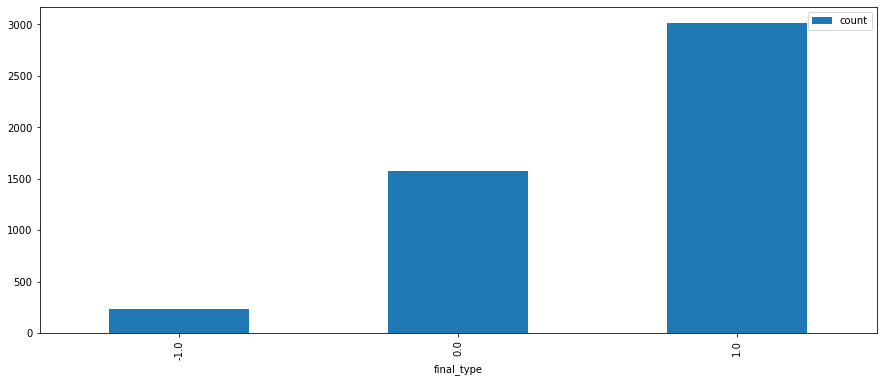

In [8]:
types_dist = df.groupby('final_type').size().reset_index()
types_dist = types_dist.rename(columns={0: 'count'})
types_dist.plot(kind='bar', x="final_type", y="count", figsize=(15,6))

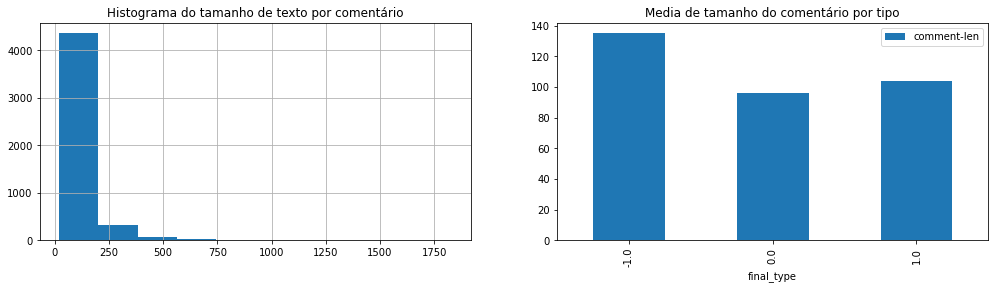

In [9]:
df["comment-len"] = df["comment"].apply(lambda x: len(x))
df_grouped = df.groupby("final_type").agg({'comment-len': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

axes[0].set_title("Histograma do tamanho de texto por comentário")
df["comment-len"].hist(ax=axes[0], bins=10)

axes[1].set_title("Media de tamanho do comentário por tipo")
df_grouped.plot.bar(x="final_type", y="comment-len", ax=axes[1])

plt.show()

#  Data Transform

In [10]:
#default transformation
df['comment'] = df['comment'].astype(str)
df['final_type'] = df['final_type'].astype(int)
df['transformed_comment'] =  df['comment'].str.lower()

In [11]:
def remove_punctuation(dfText):
    import re
    import string
    regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

    tokenized_docs_no_punctuation = []

    for review in dfText:
        # new_review = []
        new_review = ""
        for token in review:
            new_token = regex.sub(u'', token)
            if not new_token == u'':
                #new_review.append(new_token)
                new_review = new_review + new_token
            else:
                new_review = new_review + " "
        
        tokenized_docs_no_punctuation.append(new_review)
    return tokenized_docs_no_punctuation

def unicode_emoji(dfText):
    import emoji
    for emoj in emoji.UNICODE_EMOJI['pt']:
        dfText = dfText.str.replace(emoj, ' '+emoji.UNICODE_EMOJI['pt'][emoj]+' ', regex=False)
    return dfText

def normalize_utf8(dfText):
    return dfText.str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

def removing_stop_words(dfText):
    import nltk
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('portuguese') # removing stop words
    
    stopwords.append('q')
    stopwords.append('pra')
    stopwords.append('td')
    stopwords.remove('não')

    stopwords = pd.DataFrame(stopwords, columns=['normalized'])
    stopwords['normalized'] = stopwords['normalized'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

    stopword_data = []
    for idx,review in enumerate(dfText):
        new_phrase = ""
        for word in review.split(" "):
            # print(word)
            if  not stopwords['normalized'].str.match('^'+word+'$').any():
                new_phrase = new_phrase + " " + word

        stopword_data.append(new_phrase)

    return stopword_data

def portuguese_stemmer(dfText):
    # #!pip install git+git://github.com/snowballstem/pystemmer
    import Stemmer
    stemmer = Stemmer.Stemmer('portuguese')

    stemmer_docs = []
    for phrase in dfText:
        stemmer_docs.append(' '.join(stemmer.stemWords(phrase.split(" "))))

    return stemmer_docs

In [12]:
df['transformed_comment'] = remove_punctuation(df['transformed_comment']) 
df['transformed_comment'] = unicode_emoji(df['transformed_comment'])
df['transformed_comment'] = normalize_utf8(df['transformed_comment'])
df['transformed_comment'] = removing_stop_words(df['transformed_comment'])
df['transformed_comment'] = portuguese_stemmer(df['transformed_comment'])

# df['transformed_comment_withoutSteemmer'] = remove_punctuation(df['comment']) 
# df['transformed_comment_withoutSteemmer'] = unicode_emoji(df['transformed_comment_withoutSteemmer'])
# df['transformed_comment_withoutSteemmer'] = normalize_utf8(df['transformed_comment_withoutSteemmer'])
# df['transformed_comment_withoutSteemmer'] = removing_stop_words(df['transformed_comment_withoutSteemmer'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erycm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df['transformed_comment']

0        porc  compr faz 3 mes  arrepend  bug temp tod  reinic volt funcion  nao recom  vai ser prejuiz decepca compr                                                                                                         
1        assist a51 agor quer s21 kkkkkkk                                                                                                                                                                                     
2        bom problem poeir agu qued                                                                                                                                                                                           
3        samsung vier emoj iphon rend  :pessoa_fazendo_reverencia:  :simbolo_de_feminino:  :pessoa_fazendo_reverencia:  :simbolo_de_feminino:  :pessoa_fazendo_reverencia:  :simbolo_de_feminino:  enquant xaiom barat kkkkkkk
4        smartphon gam excelentent msm  fiqu desapont pq n vei fon plac vid promet                          

# Imbalance Apply

In [14]:
def overSamplDef(X_res, y_res, overMethod):
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE 
    # from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import SVMSMOTE 
    

    print('Before dataset shape %s' % sorted(Counter(y_res).items()))
    ros = overMethod()
    # ros = BorderlineSMOTE()
    # sampling_strategy='minority'
    # ros = SMOTE()
    X_res, y_res = ros.fit_resample(X_res, y_res)

    print('Resampled dataset shape %s' % sorted(Counter(y_res).items()))
    print("-------------------------------------------")
    return X_res, y_res

# Create Features

## Set y base model

In [15]:
# required_columns = 'comment'
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])

## Freature Counts

In [16]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)

## Freature Bigram

In [17]:
count_vec = CountVectorizer()
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
X_counts_bigram = count_vec_ngram.fit_transform(X)

## Freature Freq

In [18]:
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

## Freature TFDF

In [19]:
tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

## Word2Vec

In [20]:
all_commnets_list = df[required_columns].to_list()
len(all_commnets_list)

for i in range(len(all_commnets_list)):
    all_commnets_list[i] = re.sub(r"\s+", " ", all_commnets_list[i])

tokenized_words = []

for i in range(len(all_commnets_list)):
    #tokenize the text to list of sentences
    tokenized_sentence = nltk.sent_tokenize(all_commnets_list[i])
    #tokenize the list of sentences to list of words
    tokenized = [nltk.word_tokenize(sentence) for sentence in tokenized_sentence]
    #remove the stop words from the text
    for y_t, _ in enumerate(tokenized):
        tokenized_words.append([word for word in tokenized[y_t]])


all_commnets_list = tokenized_words

model = Word2Vec(all_commnets_list, min_count=1)

In [21]:
model.wv.save('eletronics_model.bin')
# import fasttext.util
embeddings = KeyedVectors.load('eletronics_model.bin')
# embeddings = KeyedVectors.load('cc.pt.300.bin')
# embeddings = fasttext.load_model("cc.pt.300.bin")
# all_commnets_list = np.array(all_commnets_list)

In [22]:
word2vec_doc_vec = pd.DataFrame()
for phrase in all_commnets_list:
  temp = pd.DataFrame()

  for word in phrase:
    try:
      word_vec = embeddings[word]
      temp = temp.append(pd.Series(word_vec), ignore_index = True)
    except:
      pass
  doc_vector = temp.mean()
  word2vec_doc_vec = word2vec_doc_vec.append(doc_vector, ignore_index = True)

word2vec_doc_vec.shape

# word2vec_doc_vec['final_type']=df['final_type']

(4832, 100)

In [23]:
X_w2d = word2vec_doc_vec

## LSA

In [24]:
tfidf_v = TfidfVectorizer()
#matrixTFIDF= tfidf_v.fit_transform(train.question_text)
matrixTFIDF= tfidf_v.fit_transform(df[required_columns])
svd=TruncatedSVD(n_components=100, n_iter=10, algorithm='arpack')
X_lsa=svd.fit_transform(matrixTFIDF) 

In [25]:
X_lsa.shape

(4832, 100)

# Traning and Test Split

In [26]:
# X_counts.reshape(-1,1)
# y.reshape(-1,1)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

X_train_w2d, X_test_w2d, y_train_w2d, y_test_w2d = train_test_split(X_w2d, y, test_size = .2)

X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(X_lsa, y, test_size=.2)

In [27]:
X_train_counts, y_train_counts = overSamplDef(X_train_counts, y_train_counts, SMOTE) #SMOTE or RandomOverSampler | BorderlineSMOTE (pior)
X_train_bigram, y_train_bigram = overSamplDef(X_train_bigram, y_train_bigram, SMOTE) #ADASYN (resultado ruim) | BorderlineSMOTE (mal distribuido)
X_train_freq, y_train_freq = overSamplDef(X_train_freq, y_train_freq, SMOTE) #RandomOverSampler or SMOTE | SVMSMOTE or RandomOverSampler
X_train_tfidf, y_train_tfidf = overSamplDef(X_train_tfidf, y_train_tfidf, SMOTE) #SMOTE | SMOTE

X_train_w2d, y_train_w2d = overSamplDef(X_train_w2d, y_train_w2d, SMOTE) #SMOTE | SMOTE
X_train_lsa, y_train_lsa = overSamplDef(X_train_lsa, y_train_lsa,SMOTE)

Before dataset shape [(0, 198), (1, 1255), (2, 2412)]
Resampled dataset shape [(0, 2412), (1, 2412), (2, 2412)]
-------------------------------------------
Before dataset shape [(0, 189), (1, 1261), (2, 2415)]
Resampled dataset shape [(0, 2415), (1, 2415), (2, 2415)]
-------------------------------------------
Before dataset shape [(0, 194), (1, 1264), (2, 2407)]
Resampled dataset shape [(0, 2407), (1, 2407), (2, 2407)]
-------------------------------------------
Before dataset shape [(0, 191), (1, 1278), (2, 2396)]
Resampled dataset shape [(0, 2396), (1, 2396), (2, 2396)]
-------------------------------------------
Before dataset shape [(0, 188), (1, 1237), (2, 2440)]
Resampled dataset shape [(0, 2440), (1, 2440), (2, 2440)]
-------------------------------------------
Before dataset shape [(0, 185), (1, 1265), (2, 2415)]
Resampled dataset shape [(0, 2415), (1, 2415), (2, 2415)]
-------------------------------------------


# Training Model

In [28]:
# mNB = MultinomialNB()

clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

clf_w2d = AdaBoostClassifier().fit(X_train_w2d, y_train_w2d)
clf_lsa = AdaBoostClassifier().fit(X_train_lsa, y_train_lsa)

In [29]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

y_pred_w2d = clf_w2d.predict(X_test_w2d)

y_pred_lsa = clf_lsa.predict(X_test_lsa)

In [30]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC(class_weight='balanced')
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

clf_w2d = GridSearchCV(svc, param_grid).fit(X_train_w2d, y_train_w2d)

clf_lsa = GridSearchCV(svc, param_grid).fit(X_train_lsa, y_train_lsa)


In [31]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

svm_y_pred_w2d = clf_w2d.predict(X_test_w2d)

svm_y_pred_lsa = clf_lsa.predict(X_test_lsa)

# Check Accuracy

In [32]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("MNB - Acuracia de counts")
print(classification_report(y_test_counts, y_pred_counts))
print("-----------------------------------------------------")
print("MNB - Acuracia de bigram")
print(classification_report(y_test_bigram, y_pred_bigram))
print("-----------------------------------------------------")

MNB - Acuracia de counts
              precision    recall  f1-score   support

           0       0.07      0.18      0.10        38
           1       0.41      0.41      0.41       323
           2       0.66      0.58      0.61       606

    accuracy                           0.51       967
   macro avg       0.38      0.39      0.37       967
weighted avg       0.55      0.51      0.53       967

-----------------------------------------------------
MNB - Acuracia de bigram
              precision    recall  f1-score   support

           0       0.07      0.70      0.13        47
           1       0.37      0.32      0.34       317
           2       0.69      0.25      0.36       603

    accuracy                           0.29       967
   macro avg       0.37      0.42      0.28       967
weighted avg       0.55      0.29      0.34       967

-----------------------------------------------------


In [33]:
print("MNB - Acuracia de freq")
print(classification_report(y_test_freq, y_pred_freq))
print("-----------------------------------------------------")
print("MNB - Acuracia de tfidf")
print(classification_report(y_test_tfidf, y_pred_tfidf))
print("-----------------------------------------------------")


MNB - Acuracia de freq
              precision    recall  f1-score   support

           0       0.09      0.48      0.15        42
           1       0.34      0.37      0.35       314
           2       0.66      0.44      0.53       611

    accuracy                           0.42       967
   macro avg       0.36      0.43      0.34       967
weighted avg       0.53      0.42      0.45       967

-----------------------------------------------------
MNB - Acuracia de tfidf
              precision    recall  f1-score   support

           0       0.09      0.36      0.14        45
           1       0.39      0.42      0.40       300
           2       0.70      0.53      0.60       622

    accuracy                           0.49       967
   macro avg       0.39      0.43      0.38       967
weighted avg       0.58      0.49      0.52       967

-----------------------------------------------------


In [34]:
print("ADA - Acuracia de w2v")
print(classification_report(y_test_w2d, y_pred_w2d))
print("-----------------------------------------------------")
print("ADA - Acuracia de lsa")
print(classification_report(y_test_lsa, y_pred_lsa))

ADA - Acuracia de w2v
              precision    recall  f1-score   support

           0       0.08      0.54      0.15        48
           1       0.39      0.39      0.39       341
           2       0.61      0.34      0.44       578

    accuracy                           0.37       967
   macro avg       0.36      0.42      0.32       967
weighted avg       0.51      0.37      0.41       967

-----------------------------------------------------
ADA - Acuracia de lsa
              precision    recall  f1-score   support

           0       0.09      0.29      0.13        51
           1       0.36      0.35      0.36       313
           2       0.64      0.52      0.58       603

    accuracy                           0.45       967
   macro avg       0.36      0.39      0.35       967
weighted avg       0.52      0.45      0.48       967



In [35]:
print("-----------------------------------------------------")
print("SVM - Acuracia de counts")
print(classification_report(y_test_counts, svm_y_pred_counts))

-----------------------------------------------------
SVM - Acuracia de counts
              precision    recall  f1-score   support

           0       0.05      0.11      0.06        38
           1       0.35      0.41      0.38       323
           2       0.64      0.53      0.58       606

    accuracy                           0.47       967
   macro avg       0.35      0.35      0.34       967
weighted avg       0.52      0.47      0.49       967



In [36]:
print("-----------------------------------------------------")
print("SVM - Acuracia de bigram")
print(classification_report(y_test_bigram, svm_y_pred_bigram))

-----------------------------------------------------
SVM - Acuracia de bigram
              precision    recall  f1-score   support

           0       0.06      0.45      0.10        47
           1       0.35      0.30      0.32       317
           2       0.64      0.34      0.44       603

    accuracy                           0.33       967
   macro avg       0.35      0.36      0.29       967
weighted avg       0.52      0.33      0.39       967



In [37]:
print("-----------------------------------------------------")
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf))

-----------------------------------------------------
SVM - Acuracia de freq
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        42
           1       0.33      0.39      0.36       314
           2       0.64      0.59      0.61       611

    accuracy                           0.50       967
   macro avg       0.36      0.36      0.36       967
weighted avg       0.52      0.50      0.51       967

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

           0       0.12      0.13      0.12        45
           1       0.35      0.40      0.38       300
           2       0.67      0.62      0.64       622

    accuracy                           0.53       967
   macro avg       0.38      0.38      0.38       967
weighted avg       0.55      0.53      0.54       967



In [38]:
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf))

SVM - Acuracia de freq
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        42
           1       0.33      0.39      0.36       314
           2       0.64      0.59      0.61       611

    accuracy                           0.50       967
   macro avg       0.36      0.36      0.36       967
weighted avg       0.52      0.50      0.51       967

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

           0       0.12      0.13      0.12        45
           1       0.35      0.40      0.38       300
           2       0.67      0.62      0.64       622

    accuracy                           0.53       967
   macro avg       0.38      0.38      0.38       967
weighted avg       0.55      0.53      0.54       967



In [39]:
print("SVM - Acuracia de w2v")
print(classification_report(y_test_w2d, svm_y_pred_w2d))
print("-----------------------------------------------------")
print("SVM - Acuracia de lsa")
print(classification_report(y_test_lsa, svm_y_pred_lsa))

SVM - Acuracia de w2v
              precision    recall  f1-score   support

           0       0.08      0.65      0.14        48
           1       0.46      0.31      0.37       341
           2       0.66      0.40      0.50       578

    accuracy                           0.38       967
   macro avg       0.40      0.45      0.34       967
weighted avg       0.56      0.38      0.43       967

-----------------------------------------------------
SVM - Acuracia de lsa
              precision    recall  f1-score   support

           0       0.08      0.47      0.14        51
           1       0.36      0.38      0.37       313
           2       0.66      0.38      0.48       603

    accuracy                           0.38       967
   macro avg       0.37      0.41      0.33       967
weighted avg       0.53      0.38      0.43       967



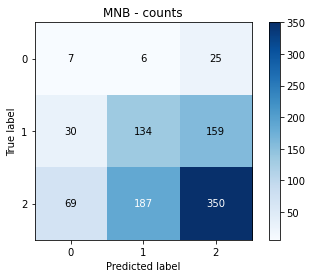

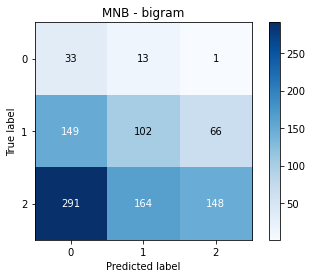

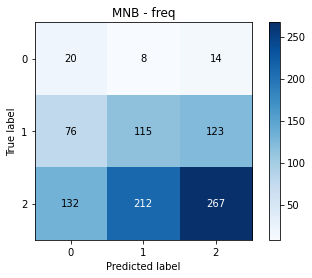

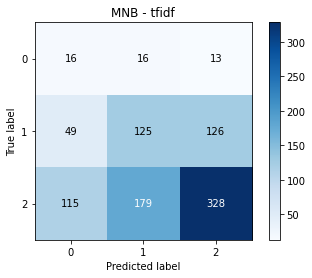

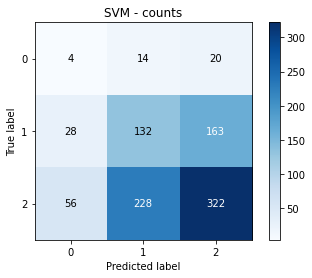

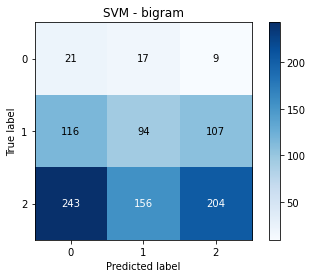

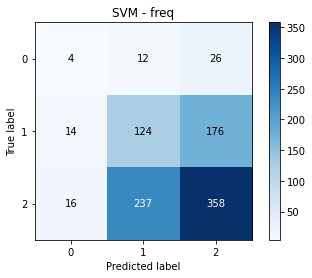

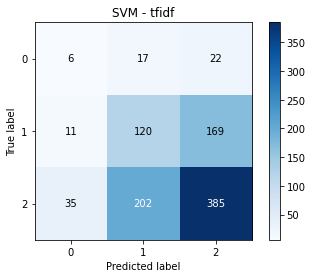

In [40]:
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(y_test_counts, y_pred_counts)
disp.set_title('MNB - counts')
disp = plot_confusion_matrix(y_test_bigram, y_pred_bigram)
disp.set_title('MNB - bigram')
disp = plot_confusion_matrix(y_test_freq, y_pred_freq)
disp.set_title('MNB - freq')
disp = plot_confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp.set_title('MNB - tfidf')

disp = plot_confusion_matrix(y_test_counts, svm_y_pred_counts)
disp.set_title('SVM - counts')
disp = plot_confusion_matrix(y_test_bigram, svm_y_pred_bigram)
disp.set_title('SVM - bigram')
disp = plot_confusion_matrix(y_test_freq, svm_y_pred_freq)
disp.set_title('SVM - freq')
disp = plot_confusion_matrix(y_test_tfidf, svm_y_pred_tfidf)
disp.set_title('SVM - tfidf')


plt.show()